# Colab setup

In [1]:
from IPython.display import clear_output

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
    ! {sys.executable} -m pip install pytorch-lifestream

clear_output()

## Data load

## Setup

In [3]:
%load_ext autoreload
%autoreload 2

# import logging
import torch
import pytorch_lightning as pl
# import warnings

# warnings.filterwarnings('ignore')
# logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

## Data preproccessing

In [4]:
import os
import pandas as pd

source_data = pd.read_csv('https://huggingface.co/datasets/dllllb/age-group-prediction/resolve/main/transactions_train.csv.gz?download=true',
                          compression='gzip')
source_data.head(2)

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017


In [5]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='client_id',
    col_event_time='trans_date',
    event_time_transformation='none',
    cols_category=['small_group'],
    cols_numerical=['amount_rur'],
    return_records=True,
)

In [6]:
%%time

dataset = preprocessor.fit_transform(source_data)

CPU times: user 55.9 s, sys: 13.8 s, total: 1min 9s
Wall time: 1min 10s


In [7]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

In [8]:
dataset = sorted(dataset, key=lambda x: x['client_id'])

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2, random_state=42)

len(train), len(test)

(24000, 6000)

In [10]:
train[0].keys()

dict_keys(['client_id', 'trans_date', 'event_time', 'small_group', 'amount_rur'])

## Embedding training

Model training in our framework organised via pytorch-lightning (pl) framework.
The key parts of neural networks training in pl are:

    * model (`pytorch_lightning.LightningModule`)
    * data loader (`torch.utils.data.DataLoader`)
    * trainer (`pytorch_lightning.Trainer`)
    
For futher details check https://pytorchlightning.ai/

### Model definition

In [11]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.bert import RtdModule

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount_rur': 'identity'},
    embeddings={
        # It is better to remove trans_date,
        # since using the date it is easy to notice the replacement in the sequence
        #'trans_date': {'in': 800, 'out': 16},
        'small_group': {'in': 250, 'out': 16},
    },
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=64,
    type='gru',
)

model = RtdModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Data loader

In [12]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.bert import RtdDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule

train_dl = PtlsDataModule(
    train_data=RtdDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[
                SeqLenFilter(min_seq_len=25),
            ],
        ),
        min_len = 600,
        max_len = 600,
    ),
    train_num_workers=2,
    train_batch_size=256,
)

### Trainer

In [73]:
import torch
import pytorch_lightning as pl

import logging

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else "auto",
    enable_progress_bar=False,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Training

In [74]:
%%time
print(f'logger.version = {trainer.logger.version}')
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type          | Params
-----------------------------------------------------
0 | _loss              | BCELoss       | 0     
1 | _seq_encoder       | RnnSeqEncoder | 20.0 K
2 | _validation_metric | AUROC         | 0     
3 | _head              | Sequential    | 65    
-----------------------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params
0.080     Total estimated model params size (MB)


logger.version = 3


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


{'loss': tensor(0.3536), 'seq_len': tensor(600.)}
CPU times: user 3min 19s, sys: 24.2 s, total: 3min 43s
Wall time: 5min 53s


### Save sequence encoder for other experiments

In [75]:
torch.save(seq_encoder.state_dict(), "rtd-emb.pt")

## Inference


In [76]:
from ptls.data_load.utils import collate_feature_dict

In [77]:
import numpy as np
import torch
from collections import defaultdict
from functools import reduce

from ptls.data_load.feature_dict import FeatureDict
from ptls.data_load.padded_batch import PaddedBatch

from transformers.tokenization_utils_base import BatchEncoding

In [78]:
inference_data = train[:3000]

In [79]:
inference_dataset = MemoryMapDataset(
    data=inference_data,
)

In [80]:
inference_dl = torch.utils.data.DataLoader(
    dataset=inference_dataset,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=32,
    num_workers=2,
)

In [81]:
from ptls.frames.inference_module import InferenceModule
from ptls.data_load.padded_batch import PaddedBatch
from itertools import chain

In [83]:
inference_module = InferenceModule(
    model=seq_encoder,
    pandas_output=True,
    drop_seq_features=False,
    model_out_name='emb')

In [84]:
inference_module.model.seq_encoder.is_reduce_sequence = False

In [85]:
predict = pl.Trainer(
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else "auto"
).predict(inference_module, inference_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [86]:
full_predict = pd.concat(predict, axis=0)
full_predict.shape

(2646251, 69)

In [87]:
full_predict.head()

,client_id,trans_date,event_time,small_group,amount_rur,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,...,emb_0054,emb_0055,emb_0056,emb_0057,emb_0058,emb_0059,emb_0060,emb_0061,emb_0062,emb_0063
0,36253,0,0,1,40.756,-0.999944,0.689444,0.436590,-0.861628,-0.942182,...,-0.281197,0.657984,-0.971727,-0.284884,-0.852577,-0.499774,-0.456695,-0.465291,-0.870806,-0.122840
1,36253,1,1,1,40.413,-0.999998,0.648132,0.376979,-0.666376,-0.996325,...,-0.373447,0.581358,-0.997420,-0.403388,-0.849408,-0.418344,-0.463797,0.251035,-0.860770,-0.128784
2,36253,2,2,1,36.788,-1.000000,0.588498,0.435898,-0.714104,-0.997517,...,-0.372284,0.518096,-0.998287,-0.458272,-0.844440,-0.323835,-0.474915,0.615958,-0.866145,-0.134356
3,36253,3,3,11,212.640,-0.977772,0.604587,0.572005,-0.935599,0.403538,...,-0.679253,0.524378,-0.799694,-0.453984,-0.545881,-0.397622,-0.244209,-0.275014,-0.873881,-0.171591
4,36253,3,3,31,255.538,-0.748471,0.628531,0.765505,-0.987866,0.183479,...,-0.842937,0.528587,-0.870956,-0.461824,-0.739728,-0.426225,-0.122032,-0.499951,-0.877514,-0.206213


In [88]:
ids_lst = [1187, 36253, 396, 38243, 1002]
vecs = full_predict.loc[full_predict['client_id'].isin(ids_lst)].copy()

In [89]:
cols_to_drop = ['client_id',
                'trans_date',
                'event_time',
                'small_group',
                'amount_rur']

In [90]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=1, n_iter=250, metric="cosine")
embs = tsne.fit_transform(vecs.drop(columns=cols_to_drop))

In [91]:
vecs['x'] = embs[:, 0]
vecs['y'] = embs[:, 1]

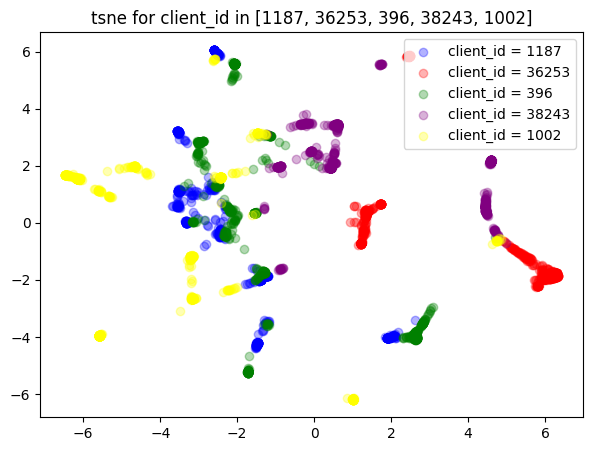

In [92]:
from matplotlib import pyplot as plt
FS = (7, 5)
fig, ax = plt.subplots(figsize=FS)
users = [1187, 36253, 396, 38243, 1002]
colors = ['b', 'r', 'g', 'purple', 'yellow', 'brown']
for usr, clr in zip(users, colors):
    ax.scatter(vecs.loc[vecs['client_id'] == usr].x,
               vecs.loc[vecs['client_id'] == usr].y,
               alpha=.3,
               color = clr,
               label = f'client_id = {usr}')
ax.set_title('tsne for client_id in [1187, 36253, 396, 38243, 1002]')
ax.legend()

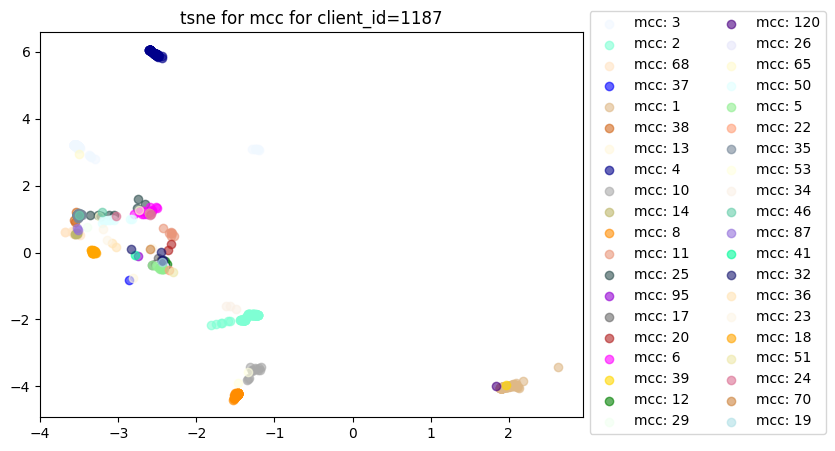

In [93]:
import matplotlib.colors as colors
FS = (7, 5)
mccs = vecs[vecs['client_id'] == 1187].small_group.unique()
colors_list = list(colors.cnames.values())
fig, ax = plt.subplots(figsize=FS)
clr = 0
for mcc in mccs:
    ax.scatter(vecs.loc[(vecs['client_id'] == 1187) & (vecs['small_group'] == mcc)].x,
               vecs.loc[(vecs['client_id'] == 1187) & (vecs['small_group'] == mcc)].y,
               alpha = .6,
               color = colors_list[clr],
               label = f'mcc: {mcc}')
    clr += len(colors_list)//len(mccs)
ax.set_title('tsne for mcc for client_id=1187')
ax.legend(ncols = 2,
          loc="center left",
          bbox_to_anchor=(0.9, 0.5),
          bbox_transform=fig.transFigure )

Text(0, 0.5, 'trans_date')

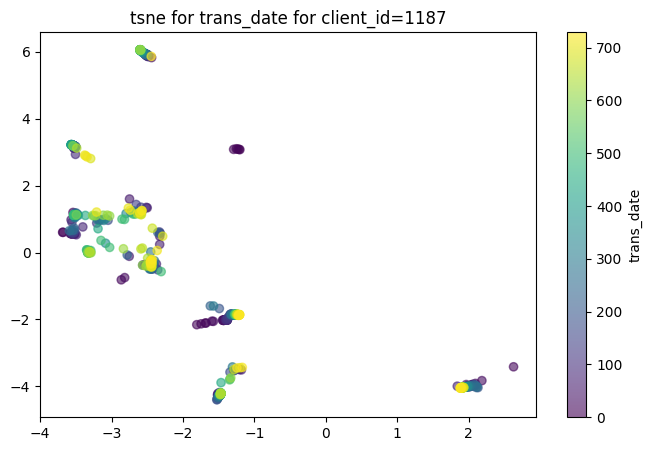

In [94]:
plt.figure(figsize=(8, 5))
plt.scatter(vecs.loc[(vecs['client_id'] == 1187)].x,
           vecs.loc[(vecs['client_id'] == 1187)].y,
           c = vecs.loc[(vecs['client_id'] == 1187)].trans_date,
           alpha = .6)
plt.title('tsne for trans_date for client_id=1187')
cbar = plt.colorbar()
cbar.ax.set_ylabel('trans_date')


Obtained embeddings can be used as features for model training

For example:

In [96]:
full_predict['next_small_group'] = full_predict.groupby('client_id')['small_group'].shift(-1)
full_predict = full_predict.dropna()
full_predict = full_predict.astype({'next_small_group': 'int64'})
cols_to_drop.append('next_small_group')

In [97]:
X = full_predict.drop(columns = cols_to_drop).values[:120000]
y = full_predict['next_small_group'].values[:120000]

In [98]:
X_train, X_test = X[:100000], X[100000:]
y_train, y_test = y[:100000], y[100000:]

In [99]:
import lightgbm as lgb
clf = lgb.LGBMClassifier(learning_rate = 0.01, random_state = 42)
clf.fit(X_train, y_train)
clear_output()

In [100]:
from sklearn.metrics import accuracy_score
y_pred=clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.34215